In [1]:
# WRITTEN BY ALAN LI
# NASA AMES LABORATORY FOR ADVANCED SENSING (LAS)
# Last edited: Oct 2, 2017

import sys
import random
import numpy as np
import cv2
import loadcoraldata_utils as coralutils
import glob
from matplotlib import pyplot as plt
import matplotlib.patches as mpatches
from collections import Counter
import pandas as pd
import logging

import keras
from keras.models import Model, Sequential
from keras.layers import Input, Dense, Dropout, Flatten, Activation
from keras.layers import Conv2D, Convolution2D, MaxPooling2D
from keras.layers.convolutional import ZeroPadding2D
from keras.layers.normalization import BatchNormalization
from keras.utils import np_utils
from keras import optimizers

# Config the matplotlib backend as plotting in line in IPython
%matplotlib notebook

Using TensorFlow backend.


<IPython.core.display.Javascript object>


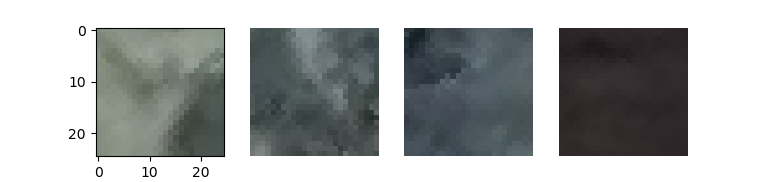

(80000, 25, 25, 3) (80000, 4)
(10000, 25, 25, 3) (10000, 4)
(10000, 25, 25, 3) (10000, 4)


In [5]:
transect1_path = '../Images/Transect 1 Hi-Res.tiff'
transect1_truth_path = '../Images/Transect 1 Truth data.tif'

image_size = 25

Transect1 = coralutils.CoralData(transect1_path, Truthpath=transect1_truth_path, truth_key=[16,160,198,38])
Transect1.generate_trainingset(image_size=image_size, N_train=20000, toremove = 3, figureson = True)
Transect1.generate_validset(image_size=image_size, N_valid=2500, toremove = 3, figureson = False)
Transect1.generate_testset(image_size=image_size, N_test=2500, toremove = 3, figureson = False)

if Transect1.train_labels.shape[-1] != Transect1.num_classes:
    Transect1.train_labels = keras.utils.to_categorical(Transect1.train_labels, Transect1.num_classes)
    Transect1.valid_labels = keras.utils.to_categorical(Transect1.valid_labels, Transect1.num_classes)
    Transect1.test_labels = keras.utils.to_categorical(Transect1.test_labels, Transect1.num_classes)

print(Transect1.train_datasets.shape, Transect1.train_labels.shape)
print(Transect1.valid_datasets.shape, Transect1.valid_labels.shape)
print(Transect1.test_datasets.shape, Transect1.test_labels.shape)

In [7]:
DROPOUT = 0.5
model_input = Input(shape = (image_size, image_size, 3))

# Model parameters
conv1_size, conv1_stride, pool1_size , pool1_stride = 7,1,2,2
conv2_size, conv2_stride, pool2_size , pool2_stride = 5,1,2,2
conv3_size, conv3_stride = 3,1
conv4_size, conv4_stride = 3,1
conv5_size, conv5_stride, pool5_size, pool5_stride = 3,1,2,2

filters1 = 96
filters2 = 256
filters3 = 384
filters4 = 384
filters5 = 256
full1 = 4096
full2 = 4096

# 1st convolutional Layer
z = Conv2D(filters = filters1, kernel_size = (conv1_size,conv1_size), strides = (conv1_stride,conv1_stride), activation = "relu")(model_input)
z = MaxPooling2D(pool_size = (pool1_size,pool1_size), strides=(pool1_stride,pool1_stride))(z)
z = BatchNormalization()(z)

# 2nd convolutional Layer
z = Conv2D(filters = filters2, kernel_size = (conv2_size,conv2_size), strides = (conv2_stride,conv2_stride), activation = "relu")(z)
z = MaxPooling2D(pool_size = (pool2_size,pool2_size), strides=(pool2_stride,pool2_stride))(z)
z = BatchNormalization()(z)

# 3rd convolutional layer
z = ZeroPadding2D(padding = (1,1))(z)
z = Conv2D(filters = filters3, kernel_size = (conv3_size,conv3_size), strides = (conv3_stride,conv3_stride), activation = "relu")(z)

# 4th convolutional layer
z = ZeroPadding2D(padding = (1,1))(z)
z = Conv2D(filters = filters4, kernel_size = (conv4_size,conv4_size), strides = (conv4_stride,conv4_stride), activation = "relu")(z)

# 5th convolutional layer
z = ZeroPadding2D(padding = (1,1))(z)
z = Conv2D(filters = filters5, kernel_size = (conv5_size,conv5_size), strides = (conv5_stride,conv5_stride), activation = "relu")(z)
z = MaxPooling2D(pool_size = (pool5_size,pool5_size), strides=(pool5_stride,pool5_stride))(z)
z = Flatten()(z)

# 6th fully connected layer
z = Dense(full1, activation="relu")(z)
z = Dropout(DROPOUT)(z)

# 7th fully connected layer
z = Dense(full2, activation="relu")(z)
z = Dropout(DROPOUT)(z)

model_output = Dense(Transect1.num_classes, activation = 'softmax')(z)

model = Model(model_input, model_output)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 25, 25, 3)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 19, 19, 96)        14208     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 9, 9, 96)          0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 9, 9, 96)          384       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 5, 5, 256)         614656    
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 2, 2, 256)         0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 2, 2, 256)         1024      
__________

In [ ]:
batch_size = 32
epochs = 1

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])
model.fit(Transect1.train_datasets, Transect1.train_labels,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(Transect1.valid_datasets, Transect1.valid_labels))
score = model.evaluate(Transect1.test_datasets, Transect1.test_labels, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Train on 80000 samples, validate on 10000 samples
Epoch 1/1
